In [1]:
using Plots, DataInterpolations, PlotThemes
theme(:dao)

In [2]:
include("../../../../git-projects/scripts/scripts/solve_ode_ivp.jl")
include("../../../../git-projects/scripts/scripts/orbital_dynamics.jl")
include("../../../../git-projects/scripts/scripts/rocket_dynamics.jl");

In [3]:
const g0 = 9.80665
const r_e = 6378.0e3;

In [4]:
h_vec = [-1000.0, 0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0]	
ρ_vec = [1.347, 1.225, 1.112, 1.007, 0.9093, 0.8194, 0.7364, 0.6601, 0.5900, 0.5258, 0.4671, 0.4135, 0.1948, 0.08891, 0.04008, 0.01841, 0.003996, 0.001027, 0.0003097, 0.00008283, 0.00001846]
ρ_interp = LinearInterpolation(ρ_vec, h_vec);

In [5]:
mass_fraction = 0.85
thrust_factor = 1.30

launch_mass = 150000
final_mass = launch_mass * (1 - mass_fraction)
mass_ratio = mass_fraction / (1 - mass_fraction)
specific_impulse = 475.0
drag_coeff = 0.5
frontal_area = pi*9^2 / 4

num_points=1000
launch_factor = thrust_factor * 1.10 * g0
meco_factor = thrust_factor * 3 * g0

mass_vec = LinRange(launch_mass, final_mass, num_points)
thrust_vec = LinRange(launch_factor*launch_mass, meco_factor*final_mass, num_points)
mass_flow_vec = thrust_vec / (specific_impulse * g0)
time_vec = (launch_mass .- mass_vec) ./ mass_flow_vec

burn_time = last(time_vec)

# defining functions wrt. time
thrust_interp = LinearInterpolation(thrust_vec, time_vec)
thrust_func(t, v, γ, h, x, density, D, g, m) = t < burn_time ? thrust_interp(t) : 0

density_func(h) = h <= last(h_vec) ? ρ_interp(h) : 0.0
drag_func(density, v) = 0.5 * density * (v^2) * frontal_area * drag_coeff
gravity_func(h) = g0 / (1 + h/r_e)^2

mass_interp = LinearInterpolation(mass_vec, time_vec)
mass_func(t) = mass_interp(t) > final_mass ? mass_interp(t) : final_mass

rocket_vars = [launch_mass, mass_ratio, drag_coeff, frontal_area]

burn_time

690.17094017094

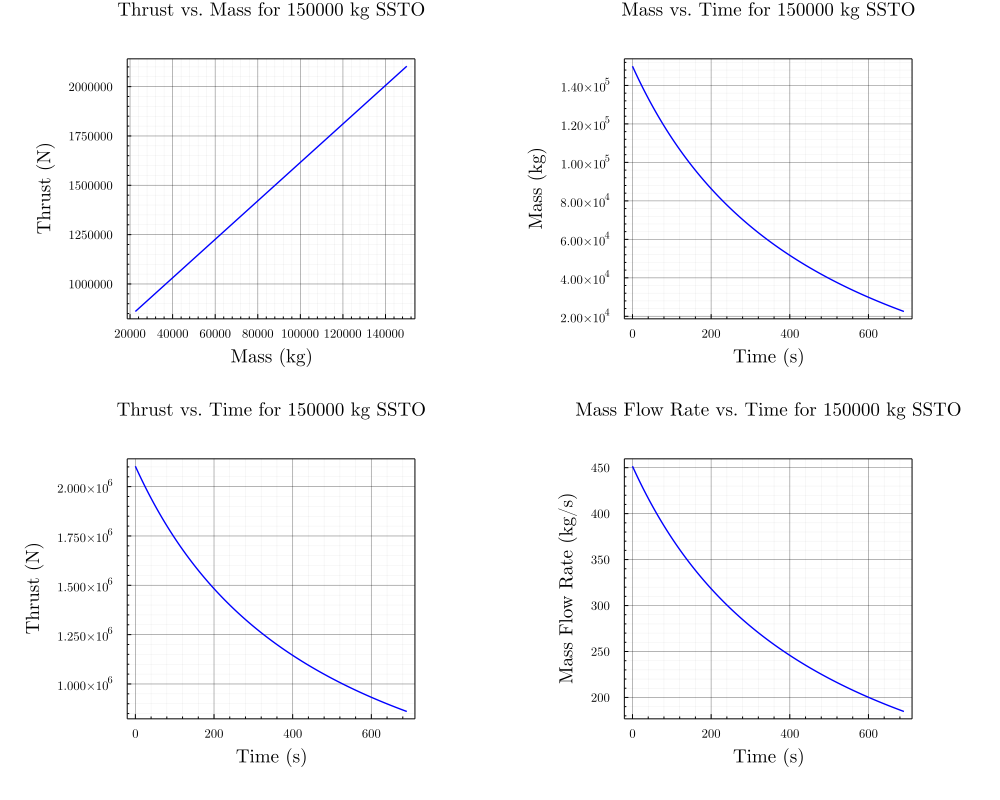

In [6]:
p1 = plot(
    mass_vec, 
    thrust_vec, 
    label="", 
    xlabel="Mass (kg)", 
    ylabel="Thrust (N)",
    title="Thrust vs. Mass for $(launch_mass) kg SSTO",
    formatter =:plain,
    color=:blue
)
	
	
p2 = plot(
    time_vec, 
    mass_vec,
    label="",
    xlabel="Time (s)",
    ylabel="Mass (kg)",
    title="Mass vs. Time for $(launch_mass) kg SSTO",
    color=:blue
)
	
	
p3 = plot(
    time_vec, 
    thrust_vec,
    label="",
    xlabel="Time (s)",
    ylabel="Thrust (N)",
    title="Thrust vs. Time for $(launch_mass) kg SSTO",
    color=:blue
)


p4 = plot(
    time_vec, 
    mass_flow_vec,
    label="",
    xlabel="Time (s)",
    ylabel="Mass Flow Rate (kg/s)",
    title="Mass Flow Rate vs. Time for $(launch_mass) kg SSTO",
    color=:blue
)

plot(p1, p2, p3, p4, size=(1000, 800), dpi=230, margin=8Plots.mm)

In [7]:
tolerance = 500; pitchover_alt = 6000; initial_conditions = [0.0, deg2rad(89), 0.0, 0.0]; sim_time = burn_time - 163.8

526.37094017094

In [8]:
part2_s, part2_t = rocket_launch_trajectory(
    rocket_vars, 
    initial_conditions, 
    0.0, 
    sim_time,
    thrust_func,
    density_func,
    drag_func,
    gravity_func,
    mass_func,
    pitchover_alt, 
    tolerance=tolerance, 
    solver_method="rk_78"
);

v_out = part2_s[1]
γ_out = part2_s[2]
h_out = part2_s[3]
x_out = part2_s[4];

size(part2_t, 1)

2785

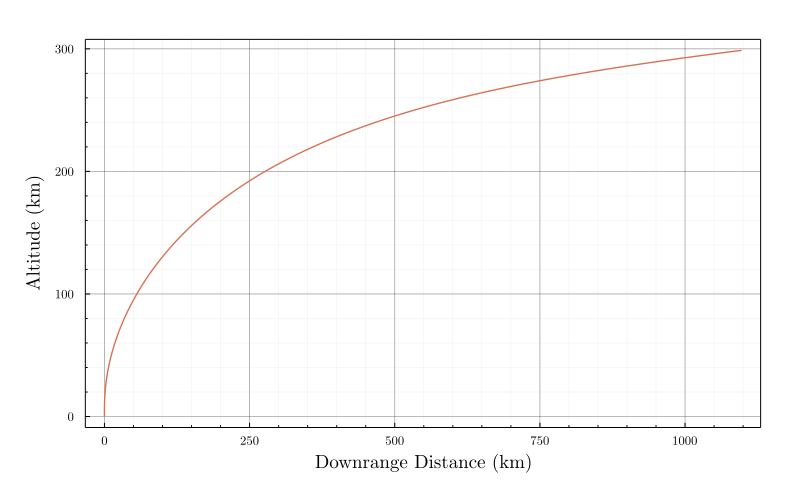

In [9]:
#=
h_plot = plot(
    x_out./1.0e3, 
    h_out./1.0e3, 
    xlabel="Downrange Distance (km)",
    ylabel="Altitude (km)",
    label=""
)

v_plot = plot(
    part2_t, 
    v_out./1.0e3, 
    xlabel="Time (s)",
    ylabel="Velocity (km/s)",
    label=""
)

γ_plot = plot(
    part2_t, 
    [rad2deg(γ) for γ in γ_out], 
    xlabel="Time (s)",
    ylabel="γ (Degrees)",
    label=""
)

plot(h_plot, v_plot, γ_plot, size=(1400,800), dpi=230, margin=8Plots.mm)
=#

plot(
    x_out./1.0e3, 
    h_out./1.0e3, 
    xlabel="Downrange Distance (km)",
    ylabel="Altitude (km)",
    legend=false,
    size=(800,500),
    dpi=230, 
    margin=8Plots.mm
)

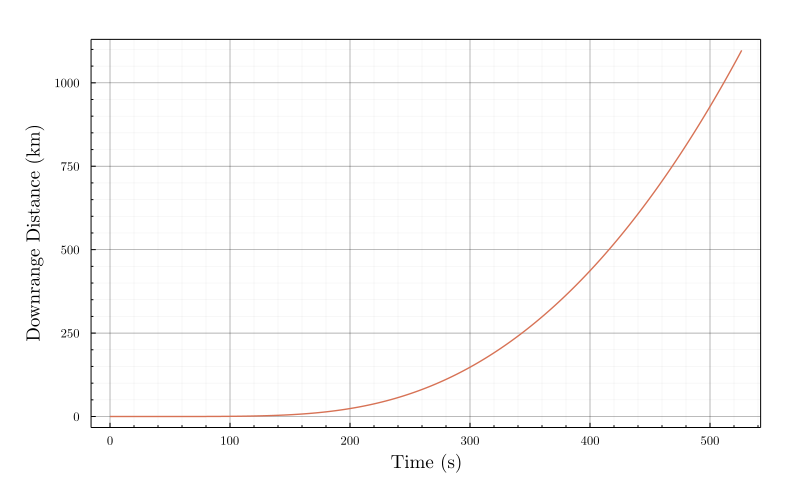

In [10]:
plot(
    part2_t,
    x_out./1.0e3, 
    ylabel="Downrange Distance (km)",
    xlabel="Time (s)",
    legend=false,
    size=(800,500),
    dpi=230, 
    margin=8Plots.mm
)

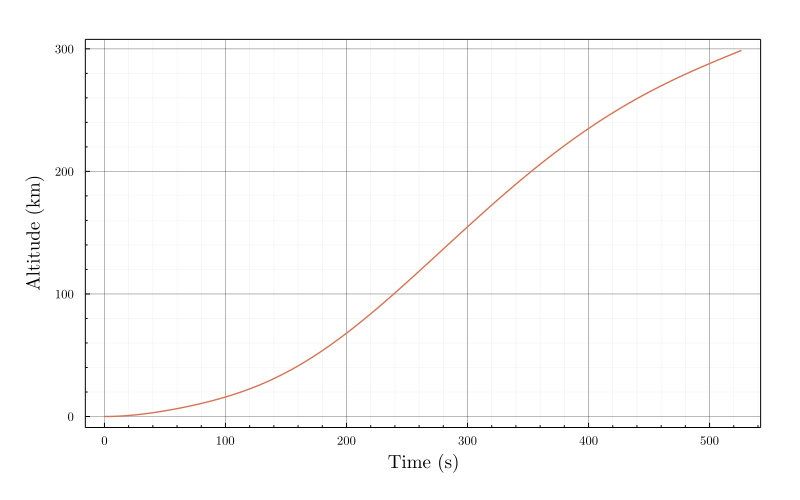

In [11]:
plot(
    part2_t,
    h_out./1.0e3, 
    ylabel="Altitude (km)",
    xlabel="Time (s)",
    legend=false,
    size=(800,500),
    dpi=230, 
    margin=8Plots.mm
)

In [12]:
earth_dist = r_e + last(h_out)
velocity = last(v_out)

theta = asin(last(x_out) / earth_dist)
alpha = last(γ_out) - theta

two_body_initial_conditions = [
    last(x_out) / 1.0e3,
    earth_dist * cos(theta) / 1.0e3,
    0.0,
    velocity * cos(alpha) / 1.0e3,
    velocity * sin(alpha) / 1.0e3,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
]

m1 = mass_func(sim_time)
m2 = 5.974e24;

In [24]:
orbit_sim_time = 15.0*60.0

s_out, t_out = two_body_propagator(
    0.0, 
    orbit_sim_time, 
    m1, 
    m2, 
    two_body_initial_conditions,
    grav_constant=6.6759e-20,
    solver_method="rk_45",
    tolerance=1.0
)

x_out_tb = s_out[1]
y_out_tb = s_out[2]

vx_out_tb = s_out[4]
vy_out_tb = s_out[5]

earth_dist_vec = h_out .+ r_e
y_burn = earth_dist_vec .* cos.(asin.(x_out ./ earth_dist_vec)) ./ 1.0e3
x_burn = x_out ./ 1.0e3;

size(t_out, 1)

609

In [25]:
function circle(x, y, r)
    θ = LinRange(0, 2*π, 500)
    x .+ r*sin.(θ), y .+ r*cos.(θ)
end

circle (generic function with 1 method)

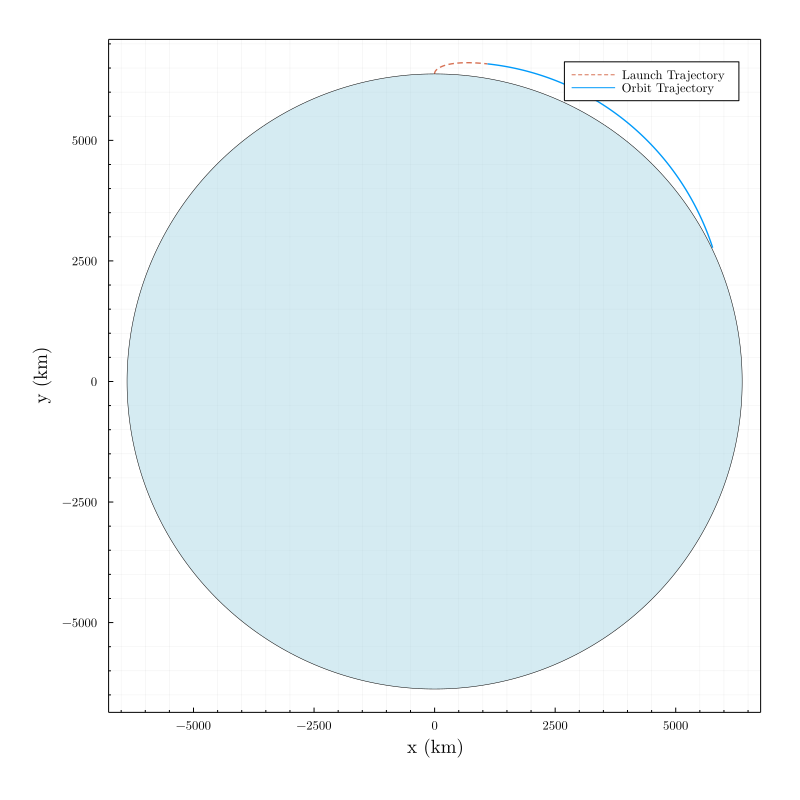

In [26]:
plot(
    x_burn, 
    y_burn,
    xlabel="x (km)",
    ylabel="y (km)",
    size=(800,800),
    dpi=230,
    aspect_ratio=:equal,
    label="Launch Trajectory",
    linestyle=:dash,
    legend=:topright,
    grid=false
)

plot!(
    x_out_tb, 
    y_out_tb,
    label="Orbit Trajectory"
)

#scatter!([last(x_out_tb)], [last(y_out_tb)], label="Rocket Position")

plot!(circle(0, 0, 6378), seriestype = [:shape,], lw=0.5, c = :lightblue, fillalpha=0.5, label="", margin=8Plots.mm)

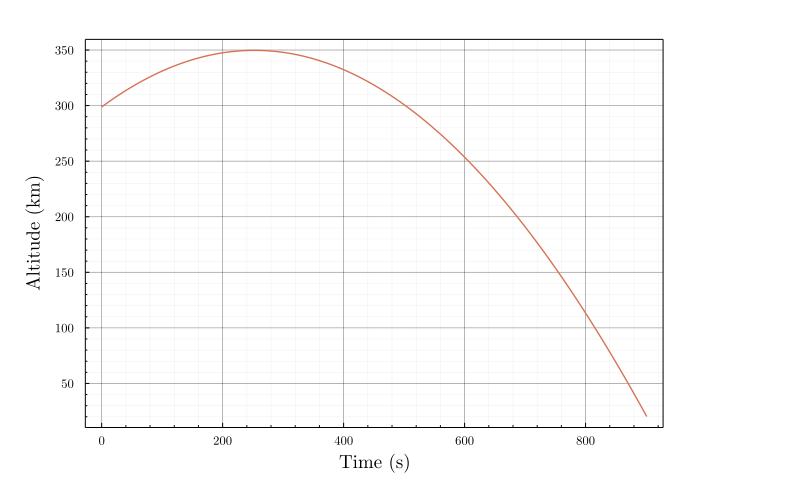

In [27]:
earth_altitude_orbit = sqrt.(x_out_tb.^2 + y_out_tb.^2) .- r_e / 1.0e3

plot(t_out, earth_altitude_orbit, xlabel="Time (s)", ylabel="Altitude (km)", label="", size=(800,500), dpi=230, margin=8Plots.mm)

In [28]:
earth_distance_orbit = sqrt.(x_out_tb.^2 + y_out_tb.^2)
orbit_per = minimum(earth_distance_orbit)
orbit_apo = maximum(earth_distance_orbit)

orbit_eccentricity = (orbit_apo - orbit_per) / (orbit_apo + orbit_per)

orbit_per - r_e/1.0e3, orbit_apo - r_e/1.0e3, orbit_eccentricity

(20.244964088576126, 349.7057429534043, 0.025099955516980174)

In [29]:
earth_apo

6727.693724094532

In [31]:
earth_apo

6727.705742953404

In [30]:
apo_index = findmax(earth_distance_orbit)[2]
#apo_index = 32
earth_apo = earth_distance_orbit[apo_index]

earth_mu = 398600 
required_vel_apo = sqrt(earth_mu / orbit_apo) * 1.0e3

time_apo = t_out[apo_index]

vx_apo = vx_out_tb[apo_index]
vy_apo = vy_out_tb[apo_index]

current_vel_apo = sqrt(vx_apo^2 + vy_apo^2) * 1.0e3
required_delta_v = required_vel_apo - current_vel_apo
required_final_mass = m1 / exp(required_delta_v / (specific_impulse * g0))

thrust_circularization = 2.5*g0*m1
mass_flux_circularization = thrust_circularization / (specific_impulse * g0)

circ_time = (m1 - required_final_mass) / mass_flux_circularization

circ_rocket_vars = [m1, m1 / final_mass, drag_coeff, frontal_area]

circ_thrust_func(t, v, γ, h, x, density, D, g, m) = thrust_circularization
circ_mass_func(t) = m1 - mass_flux_circularization*t

circ_mass_func (generic function with 1 method)

In [33]:
apo_time = t_out[apo_index]
circ_start_time = apo_time - circ_time/2

vx_time_interp = LinearInterpolation(vx_out_tb, t_out)
vy_time_interp = LinearInterpolation(vy_out_tb, t_out)
alt_time_interp = LinearInterpolation(earth_altitude_orbit, t_out)

vx_circ_start = vx_time_interp(circ_start_time)
vy_circ_start = vy_time_interp(circ_start_time)
alt_circ_start = alt_time_interp(circ_start_time)

349.5409508669078

In [34]:
# v γ h x
circ_initial_conditions = [sqrt(vx_circ_start^2 + vy_circ_start^2) * 1.0e3, 0, alt_circ_start * 1.0e3, 0]

4-element Vector{Float64}:
   6964.283682891763
      0.0
 349540.9508669078
      0.0

In [35]:
circ_s, circ_t = rocket_launch_trajectory(
    circ_rocket_vars, 
    circ_initial_conditions, 
    0.0, 
    circ_time,
    circ_thrust_func,
    density_func,
    drag_func,
    gravity_func,
    circ_mass_func,
    0, 
    tolerance=15, 
    solver_method="rk_78"
);

v_out_circ = circ_s[1]
γ_out_circ = circ_s[2]
h_out_circ = circ_s[3]
x_out_circ = circ_s[4];

size(circ_t, 1)

15848

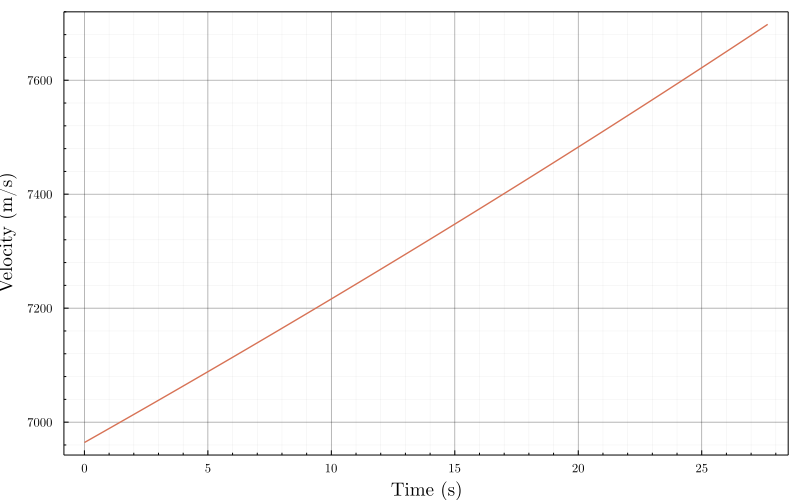

In [36]:
plot(circ_t, v_out_circ, legend=false, size=(800,500), dpi=230, xlabel="Time (s)", ylabel="Velocity (m/s)")

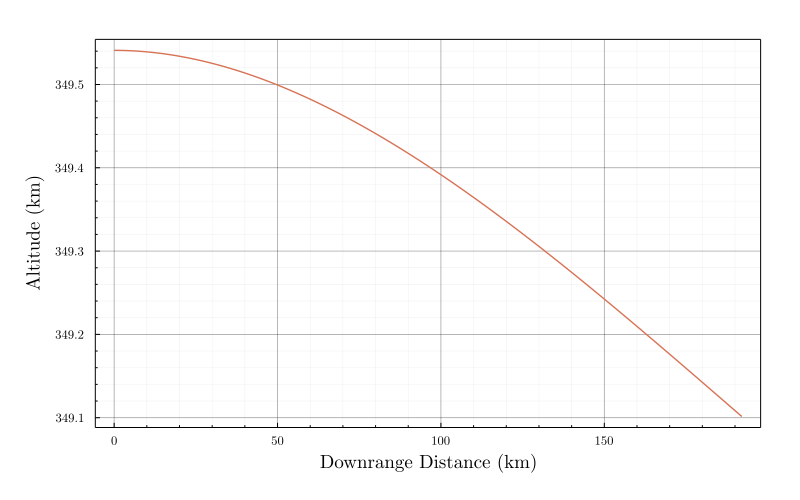

In [37]:
plot(
    x_out_circ./1.0e3, 
    h_out_circ./1.0e3, 
    xlabel="Downrange Distance (km)",
    ylabel="Altitude (km)",
    legend=false,
    size=(800,500),
    dpi=230, 
    margin=8Plots.mm
)

In [38]:
earth_altitude_orbit[30], first(h_out_circ) / 1.0e3

(315.4132258115642, 349.5409508669078)

In [39]:
earth_dist_circ = r_e + last(h_out_circ)
velocity_circ = last(v_out_circ)

theta_circ = asin(last(x_out_circ) / earth_dist_circ)
alpha_circ = last(γ_out_circ) - theta_circ

x_time_interp = LinearInterpolation(x_out_tb, t_out)
y_time_interp = LinearInterpolation(y_out_tb, t_out)

circ_start_x = x_time_interp(circ_start_time)
circ_start_y = y_time_interp(circ_start_time)
ν0_circ = atan(circ_start_y / circ_start_x)

θ_transform = ν0_circ - π/2
y_out_circ = h_out_circ .+ r_e

x_burn_transform = (x_out_circ .* cos(θ_transform) .- y_out_circ .* sin(θ_transform)) ./ 1.0e3
y_burn_transform = (x_out_circ .* sin(θ_transform) .+ y_out_circ .* cos(θ_transform)) ./ 1.0e3

ν_circ = atan(last(y_burn_transform) / last(x_burn_transform));

In [40]:
β_circ = ν_circ + last(γ_out_circ) - π/2
m1_circ = circ_mass_func(circ_time)

circ_ic2 = [
    earth_dist_circ * cos(ν_circ) / 1.0e3,
    earth_dist_circ * sin(ν_circ) / 1.0e3,
    0.0,
    velocity_circ * cos(β_circ) / 1.0e3,
    velocity_circ * sin(β_circ) / 1.0e3,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
];

In [41]:
orbit_sim_time_circ = 118.0*60.0

s_out_circ, t_out_circ = two_body_propagator(
    0.0, 
    orbit_sim_time_circ, 
    m1_circ, 
    m2, 
    circ_ic2,
    grav_constant=6.6759e-20,
    solver_method="rk_45",
    tolerance=10.0
)

x_out_tb_circ = s_out_circ[1]
y_out_tb_circ = s_out_circ[2]

vx_out_tb_circ = s_out_circ[4]
vy_out_tb_circ = s_out_circ[5]

earth_dist_vec_circ = h_out_circ .+ r_e
y_burn_circ = earth_dist_vec_circ .* cos.(asin.(x_out_circ ./ earth_dist_vec_circ)) ./ 1.0e3
x_burn_circ = x_out_circ ./ 1.0e3;

size(t_out_circ, 1)

539

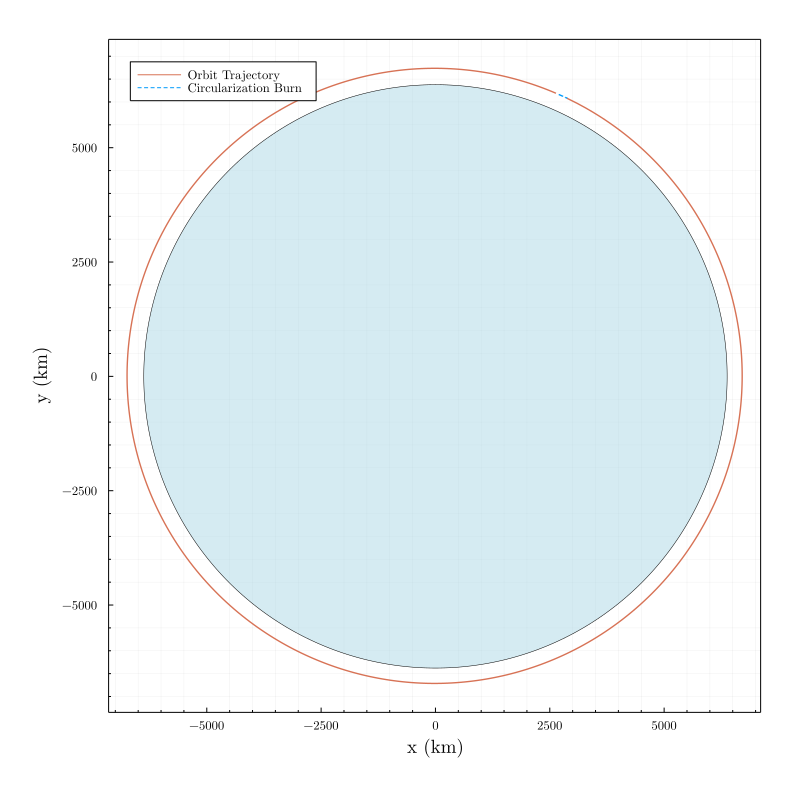

In [42]:
plot(
    x_out_tb_circ[1:414], 
    y_out_tb_circ[1:414],
    xlabel="x (km)",
    ylabel="y (km)",
    size=(800,800),
    dpi=230,
    aspect_ratio=:equal,
    label="Orbit Trajectory",
    legend=:topleft,
    grid=false
)

plot!(x_burn_transform, y_burn_transform, label="Circularization Burn", linestyle=:dash)

#scatter!([last(x_out_tb)], [last(y_out_tb)], label="Rocket Position")

plot!(circle(0, 0, 6378), seriestype = [:shape,], lw=0.5, c = :lightblue, fillalpha=0.5, label="", margin=8Plots.mm)

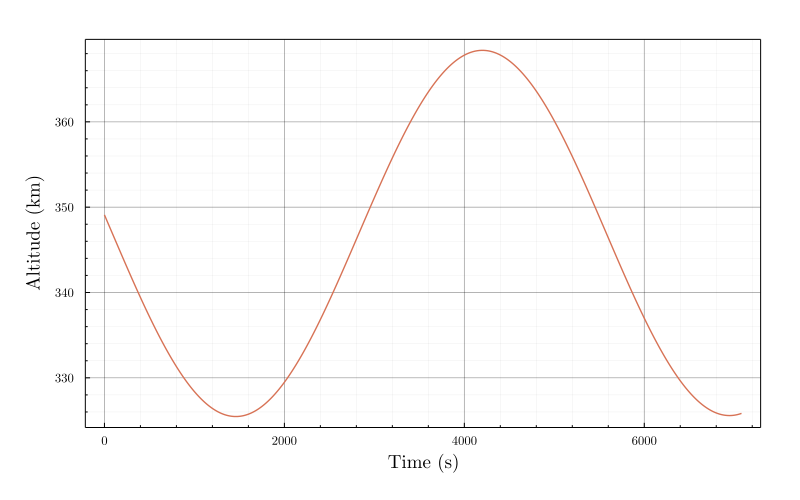

In [43]:
earth_altitude_circ = sqrt.(x_out_tb_circ.^2 + y_out_tb_circ.^2) .- r_e / 1.0e3
plot(t_out_circ, earth_altitude_circ, xlabel="Time (s)", ylabel="Altitude (km)", legend=false, size=(800,500), dpi=230, margin=8Plots.mm)

In [34]:
findmax(earth_altitude_circ)

(368.2909454830078, 318)

In [36]:
sqrt(vx_out_tb_circ[318]^2 + vy_out_tb_circ[318]^2)

7.676082603057246

In [44]:
earth_distance_orbit_circ = sqrt.(x_out_tb_circ.^2 + y_out_tb_circ.^2)
orbit_per_circ = minimum(earth_distance_orbit_circ)
orbit_apo_circ = maximum(earth_distance_orbit_circ)

orbit_eccentricity_circ = (orbit_apo_circ - orbit_per_circ) / (orbit_apo_circ + orbit_per_circ)

orbit_per_circ, orbit_apo_circ, orbit_eccentricity_circ

(6703.462092290916, 6746.381667466347, 0.0031910835502675836)

In [29]:
sum(earth_distance_orbit_circ) / size(earth_distance_orbit_circ, 1) - r_e/1.0e3

343.6946963886621

In [47]:
x_coast = [x_time_interp(t) for t ∈ LinRange(0, circ_start_time, 100)]
y_coast = [y_time_interp(t) for t ∈ LinRange(0, circ_start_time, 100)];

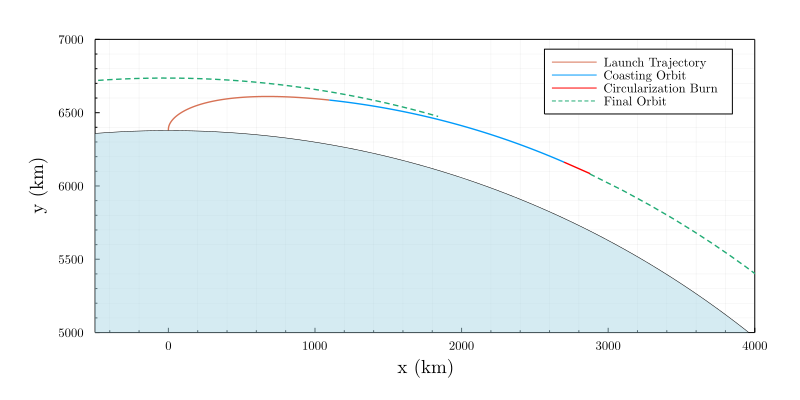

In [58]:
plot(
    x_burn, 
    y_burn,
    label="Launch Trajectory",
    xlabel="x (km)",
    ylabel="y (km)",
    size=(800,400),
    dpi=230,
    aspect_ratio=:equal,
    legend=:topright,
    grid=false,
    xlim=(-500, 4000),
    ylim=(5000, 7000)
)

plot!(
    x_coast, 
    y_coast,
    label="Coasting Orbit"
)


plot!(
    x_burn_transform, y_burn_transform, label="Circularization Burn", c=:red
)

plot!(
    x_out_tb_circ[1:405], 
    y_out_tb_circ[1:405],
    label="Final Orbit",
    linestyle=:dash
)

plot!(circle(0, 0, 6378), seriestype = [:shape,], lw=0.5, c = :lightblue, fillalpha=0.5, label="", margin=8Plots.mm)

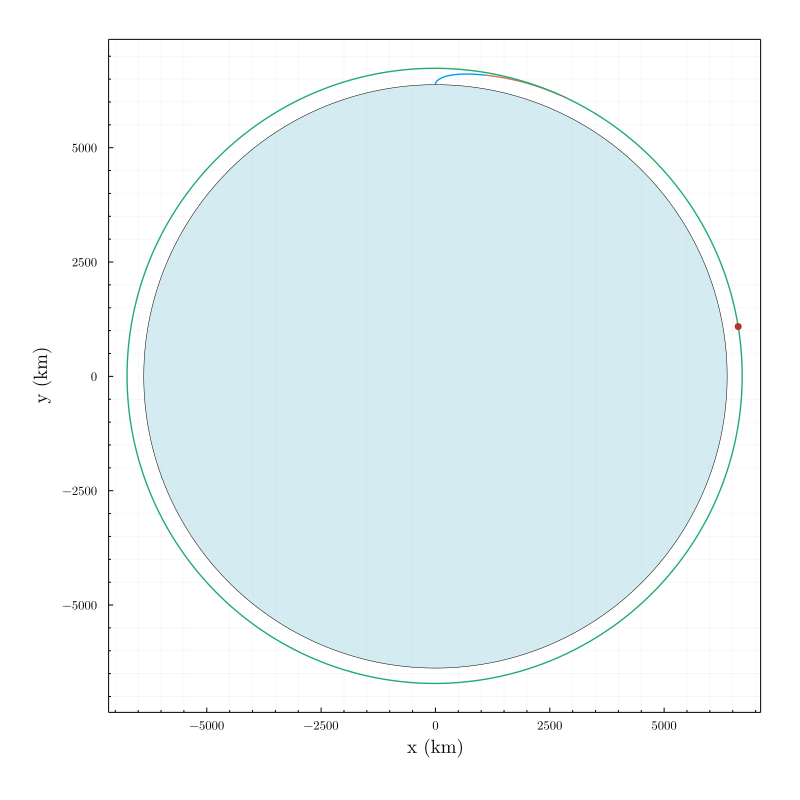

In [66]:
plot(
    x_out_tb[1:30], 
    y_out_tb[1:30],
    xlabel="x (km)",
    ylabel="y (km)",
    size=(800,800),
    dpi=230,
    aspect_ratio=:equal,
    legend=:false,
    grid=false
)

plot!(
    x_burn, 
    y_burn,
    label="Launch Trajectory",
)


plot!(
    x_burn_transform, y_burn_transform, label="Circularization Burn"
)

plot!(
    x_out_tb_circ[1:415], 
    y_out_tb_circ[1:415],
    label="Adjusted Circular Orbit"
)


plot!(circle(0, 0, 6378), seriestype = [:shape,], lw=0.5, c = :lightblue, fillalpha=0.5, label="", margin=8Plots.mm)

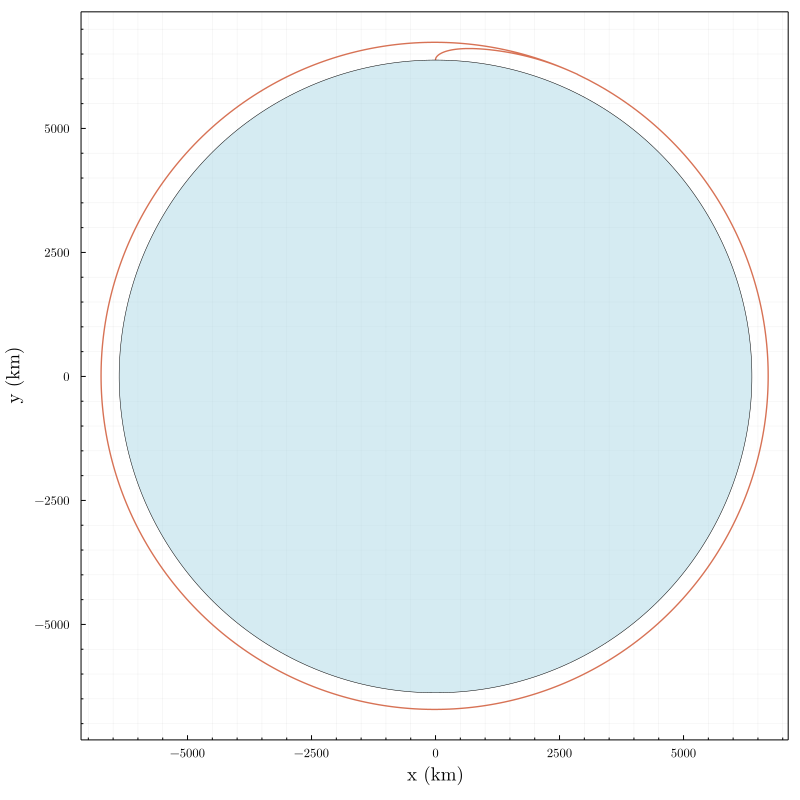

In [109]:
rocket_total_x = [x_burn; x_out_tb[1:30]; x_burn_transform; x_out_tb_circ[1:415]]
rocket_total_y = [y_burn; y_out_tb[1:30]; y_burn_transform; y_out_tb_circ[1:415]]
tocket_total_t = [part2_t; t_out[1:30] .+ last(part2_t); circ_t .+ (last(t_out[1:30]) + last(part2_t)); t_out_circ[1:415] .+ (last(circ_t) + last(t_out[1:30]) + last(part2_t))]

plot(rocket_total_x, rocket_total_y, xlabel="x (km)", ylabel="y (km)", size=(800,800), dpi=230, aspect_ratio=:equal, legend=:false, grid=false)
plot!(circle(0, 0, 6378), seriestype = [:shape,], lw=0.5, c = :lightblue, fillalpha=0.5, label="")

In [68]:
rocket_x_interp = LinearInterpolation(rocket_total_x, tocket_total_t)
rocket_y_interp = LinearInterpolation(rocket_total_y, tocket_total_t)

t_new = LinRange(0.0, last(tocket_total_t), 2000);
rocket_x_anim = [rocket_x_interp(t) for t in t_new]
rocket_y_anim = [rocket_y_interp(t) for t in t_new];

In [69]:
size(rocket_y_anim)

(2000,)

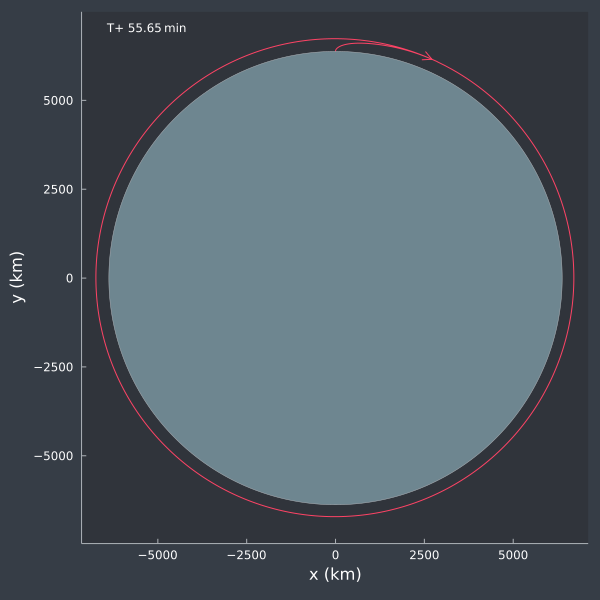

In [124]:
plot(rocket_x_anim, rocket_y_anim, arrow=true, xlabel="x (km)", ylabel="y (km)", size=(600,600), dpi=230, aspect_ratio=:equal, legend=:false, grid=false)

annotate!((0.05, 0.97), text("T+ 55.65", 8, :left, :white))
annotate!((0.165, 0.97), text("min", 8, :left, :white))


plot!(circle(0, 0, 6378), seriestype = [:shape,], lw=0.5, c = :lightblue, fillalpha=0.5, label="")
#scatter!(rocket_x_anim, rocket_y_anim, )

In [110]:
theme(:dark)

In [125]:
function animate(i)
    plot(rocket_x_anim[1:i], rocket_y_anim[1:i], arrow=true, xlabel="x (km)", ylabel="y (km)", size=(600,600), dpi=230, aspect_ratio=:equal, legend=:false, grid=false, c=:orange, margin=5Plots.mm)

    annotate!((0.05, 0.97), text("T+ $(round(t_new[i] / 60, digits=2))", 8, :left, :white))
    annotate!((0.165, 0.97), text("min", 8, :left, :white))

    if t_new[i] <= last(part2_t)
        launch_stage = "Launch"
    elseif t_new[i] <= last(t_out[1:30]) + last(part2_t)
        launch_stage = "Coast"
    elseif t_new[i] <= last(t_out[1:30]) + last(part2_t) + last(circ_t)
        launch_stage = "Circularization"
    else
        launch_stage = "Final Orbit"
    end

    annotate!((0.05, 0.92), text("Stage: $(launch_stage)", 8, :left, :white))
    
    plot!(circle(0, 0, 6378), seriestype = [:shape,], lw=0.5, c = :lightblue, fillalpha=0.5, label="")
end

animate (generic function with 1 method)

In [126]:
anim = @animate for i ∈ 1:size(t_new, 1)
    animate(i)
end

Animation("C:\\Users\\mjski\\AppData\\Local\\Temp\\jl_hVVXFM", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "001991.png", "001992.png", "001993.png", "001994.png", "001995.png", "001996.png", "001997.png", "001998.png", "001999.png", "002000.png"])